In [4]:
!pip install numpy torch


In [24]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [25]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rajat95gupta/smartphone-image-denoising-dataset")
path = path + "/SIDD_Small_sRGB_Only" + "/Data"

print("Path to image files:", path)

Path to image files: /root/.cache/kagglehub/datasets/rajat95gupta/smartphone-image-denoising-dataset/versions/1/SIDD_Small_sRGB_Only/Data


In [32]:
def create_dataset():
  data = []
  for filename in os.listdir(path):
    gt_path = None
    noisy_path = None
    for f in os.listdir(os.path.join(path, filename)):
        if f.startswith('GT_'):
            gt_path = os.path.join(path,filename, f)

        elif f.startswith('NOISY_'):
            noisy_path = os.path.join(path, filename, f)

    data.append({'gt':gt_path, 'noisy':noisy_path})

  return data

In [39]:
from PIL import Image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        gt_path = self.data[idx]['gt']
        noisy_path = self.data[idx]['noisy']
        gt = Image.open(gt_path)
        noisy = Image.open(noisy_path)
        if self.transform:
            gt = self.transform(gt)
            noisy = self.transform(noisy)
        return gt, noisy


In [42]:
NUM_TRAIN = 144
TARGET_SIZE = (400, 400)  # Example: Resize to 224x224 pixels

data = create_dataset()

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(TARGET_SIZE),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

train = CustomImageDataset(data, transform=transform)
loader_train = DataLoader(train, batch_size=4,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomImageDataset(data, transform=transform)
loader_val = DataLoader(val, batch_size=4,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 160)))

test = CustomImageDataset(data, transform=transform)
loader_test = DataLoader(test, batch_size=4)

Show sample images from training set

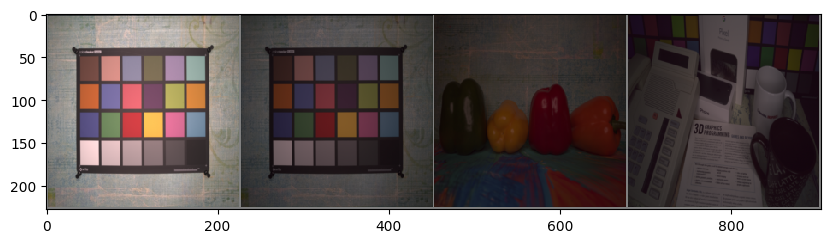

In [43]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(loader_train)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd

def train(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[], verbose=True):
  """
  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for

  Returns: Accuracy History, also prints model accuracies during training.
  """
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  num_iters = epochs * len(loader_train)
  if verbose:
    num_prints = num_iters // print_every + 1
  else:
    num_prints = epochs
  acc_history = torch.zeros(num_prints, dtype=torch.float)
  iter_history = torch.zeros(num_prints, dtype=torch.long)

  for e in range(epochs):

    adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)

    for t, (x, y) in enumerate(loader_train):
      model.train()  # put model to training mode
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # This is the backwards pass: compute the gradient of the loss with
      # respect to each  parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients
      # computed by the backwards pass.
      optimizer.step()

      tt = t + e * len(loader_train)

      if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader_train)-1)):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy(loader_val, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        print()
      elif not verbose and (t == len(loader_train)-1):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy(loader_val, model)
        acc_history[e] = acc
        iter_history[e] = tt
        print()
  return acc_history, iter_history

Denoinsing Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def flatten(x, start_dim=1, end_dim=-1):
  return x.flatten(start_dim=start_dim, end_dim=end_dim)

class Flatten(nn.Module):
  def forward(self, x):
    return flatten(x)

class Reshape(nn.Module):
  def forward(self, x):
    return torch.reshape(x, [128,50,50])

def block(in_dim, out_dim, width):
    return nn.Sequential(
        nn.Conv2d(in_dim, in_dim, 3+2*width, padding=width+1),
        nn.BatchNorm2d(out_dim),
        nn.reLU(),
        nn.Conv2d(in_dim, out_dim, 1+2*width, padding=width),
        nn.BatchNorm2d(out_dim),
        nn.reLU(),
        nn.Conv2d(out_dim, out_dim, 1+2*width, padding=width)
    )

class ConvResBlock(nn.Module):
    def __init__(self, in_dim, out_dim, width):
        super().__init__()
        self.block = block(in_dim, out_dim, width)
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.m = nn.MaxPool2d(2)

    def forward(self, x):
        x = x + self.block(x)
        x = self.m(x)

        return x

class TransConvResBlock(nn.Module):
  def __init__(self, in_dim, out_dim, width):
    super().__init__()
    self.block = block(in_dim, out_dim, width)
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.d = nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
      x = x + self.block(x)
      x = self.d(x)

      return x

model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    ConvResBlock(16, 32, 1),
    ConvResBlock(32, 64, 1),
    ConvResBlock(64, 128, 1),
    Flatten(),
    nn.Linear(128*50*50, 128*50*50),
    nn.ReLU(),
    nn.Dropout(),
    Reshape(),
    TransConvResBlock(128, 64, 1),
    TransConvResBlock(64, 32, 1),
    TransConvResBlock(32, 16, 1),
    nn.Conv2d(16, 3, 3, padding=1)
)
